# Building the Neural Model
Here we'll try and build and then simulate the neural model for the rat hindlimb
## Step 1: Imports

In [66]:
# Add the library to the path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Import packages and modules for designing the network
from sns_toolbox.design.neurons import NonSpikingNeuron
from sns_toolbox.design.connections import NonSpikingSynapse
from sns_toolbox.design.networks import Network

# Import packages and modules for simulating the network
import numpy as np
import matplotlib.pyplot as plt
from sns_toolbox.simulate.backends import SNS_Numpy

## Step 2: Building the Network
Working off of the hand tuned parameters, we can create the three types of neurons and 12 connections between them.

In [67]:
motor_neuron  = NonSpikingNeuron(name="MN",color="green",
                                 membrane_capacitance=5.0,
                                 membrane_conductance=1,
                                 membrane_rest_potential=-62.0,
                                 pre_synaptic_saturation=-54.35,
                                 pre_synaptic_threshold=-78,
                                 bias=0
                                )
one_a         = NonSpikingNeuron(name="1a",color="red",
                                 membrane_capacitance=30.0,
                                 membrane_conductance=1,
                                 membrane_rest_potential=-60.0,
                                 pre_synaptic_saturation=-40,
                                 pre_synaptic_threshold=-62,
                                 bias=0
                                )
renshaw_cell = NonSpikingNeuron(name="RC",color="blue",
                                 membrane_capacitance=130.0,
                                 membrane_conductance=1,
                                 membrane_rest_potential=-50.5,
                                 pre_synaptic_saturation=-40.0,
                                 pre_synaptic_threshold=-60.0,
                                 bias=0
                                )
one_a_flx_one_a_ext = NonSpikingSynapse(max_conductance=2.5,   relative_reversal_potential=-99.7+60)
one_a_ext_one_a_flx = NonSpikingSynapse(max_conductance=2.198, relative_reversal_potential=-99.7+60)
one_a_flx_mn_ext =    NonSpikingSynapse(max_conductance=1.076, relative_reversal_potential=-100.+62)
one_a_ext_mn_flx =    NonSpikingSynapse(max_conductance=10,    relative_reversal_potential=-100.+62)
mn_flx_rc_flx =       NonSpikingSynapse(max_conductance=0.6,   relative_reversal_potential=0+50.5)
mn_ext_rc_ext =       NonSpikingSynapse(max_conductance=0.5,   relative_reversal_potential=0+50.5)
rc_ext_one_a_ext =    NonSpikingSynapse(max_conductance=5.0,   relative_reversal_potential=-70.+60)
rc_flx_one_a_flx =    NonSpikingSynapse(max_conductance=4.2,   relative_reversal_potential=-70.+60)
rc_ext_mn_ext =       NonSpikingSynapse(max_conductance=0.55,  relative_reversal_potential=-70.+62)
rc_flx_mn_flx =       NonSpikingSynapse(max_conductance=0.45,  relative_reversal_potential=-70.+62)
rc_flx_rc_ext =       NonSpikingSynapse(max_conductance=1.8,   relative_reversal_potential=-100.+50.5)
rc_ext_rc_flx =       NonSpikingSynapse(max_conductance=0.001,   relative_reversal_potential=-100.+50.5)


Next, we add all of the newly created neurons and connection to our network, graphing to sanity check

In [95]:
net = Network(name='Rat Hindlimb Neural Model', R=0.1)

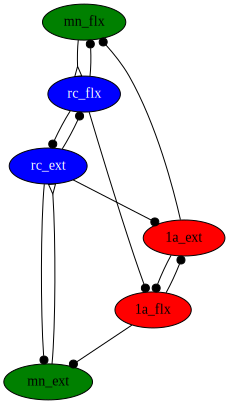

In [96]:
net.add_neuron(motor_neuron,name="mn_flx")
net.add_neuron(motor_neuron,name="mn_ext")
net.add_neuron(one_a,name="1a_flx")
net.add_neuron(one_a,name="1a_ext")
net.add_neuron(renshaw_cell,name="rc_flx")
net.add_neuron(renshaw_cell,name="rc_ext")

net.add_connection(one_a_flx_one_a_ext,"1a_flx","1a_ext")
net.add_connection(one_a_ext_one_a_flx,"1a_ext","1a_flx")
net.add_connection(one_a_flx_mn_ext,"1a_flx","mn_ext")
net.add_connection(one_a_ext_mn_flx,"1a_ext","mn_flx")
net.add_connection(mn_flx_rc_flx,"mn_flx","rc_flx")
net.add_connection(mn_ext_rc_ext,"mn_ext","rc_ext")
net.add_connection(rc_ext_one_a_ext,"rc_ext","1a_ext")
net.add_connection(rc_flx_one_a_flx,"rc_flx","1a_flx")
net.add_connection(rc_ext_mn_ext,"rc_ext","mn_ext")
net.add_connection(rc_flx_mn_flx,"rc_flx","mn_flx")
net.add_connection(rc_flx_rc_ext,"rc_flx","rc_ext")
net.add_connection(rc_ext_rc_flx,"rc_ext","rc_flx")

net.graph

Lastly, we add inputs and outputs

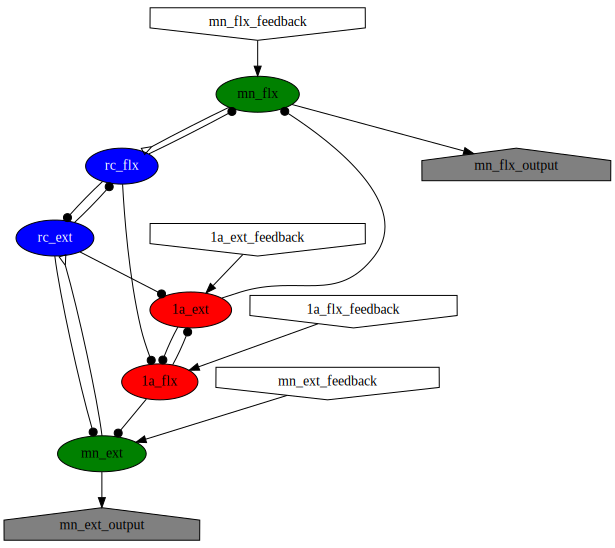

In [97]:
net.add_input(dest='mn_flx', name='mn_flx_feedback', color='white')
net.add_input(dest='mn_ext', name='mn_ext_feedback', color='white')
net.add_input(dest='1a_flx', name='1a_flx_feedback', color='white')
net.add_input(dest='1a_ext', name='1a_ext_feedback', color='white')

net.add_output(source='mn_flx',name='mn_flx_output',color='grey')
net.add_output(source='mn_ext',name='mn_ext_output',color='grey')
net.graph

## Step 2.5: Adding Fake Data with Gain
For these hand tuned values, we're adding fake data, and adding a gian to it to make it work better

In [98]:
import csv
t = []
flx = []
ext = []
with open("DataTool_1.txt",'r') as file:
    reader = csv.reader(file, delimiter="\t")
    for line in reader:
        t.append(line[0])
        ext.append(line[1])
        flx.append(line[2])
def apply_gain(inp,m,b):
    return inp * m * 1000.0 + b

to_one_a_flx = apply_gain(np.array(flx,dtype="float64"),10.032,-2.864)
to_mn_flx = apply_gain(np.array(flx,dtype="float64"),2.04,-0.599)
to_one_a_ext = apply_gain(np.array(ext,dtype="float64"),10.04,-2.234)
to_mn_ext = apply_gain(np.array(ext,dtype="float64"),1.002,-2.27)

inputs = np.array([to_mn_flx,to_mn_ext,to_one_a_flx,to_one_a_ext])
inputs = inputs.transpose()
print(inputs.shape)
inputs[0]

(200001, 4)


array([ 612.278404 ,  227.9796802, 3011.0507632, 2304.858604 ])

In [99]:
dt = 0.00005
t_max = 5
inputs = np.zeros([len(t),4])+20

In [100]:
model = SNS_Numpy(net, dt=dt, spiking=False, debug=True)

#
GETTING NET PARAMETERS
#
Number of Populations:
6
Number of Neurons:
6
Number of Connections
12
Number of Inputs:
4
Number of Outputs:
Network Voltage Range (mV):
#
INITIALIZING VARIABLES AND PARAMETERS
#
#
SETTING NEURAL PARAMETERS
#
#
SETTING INPUT PARAMETERS
#
#
SETTING CONNECTION PARAMETERS
#
#
CALCULATING TIME FACTORS
#
#
INITIALIZING PROPAGATION DELAY
#
#
SETTING OUTPUT PARAMETERS
#
#
ALL FINAL PARAMETERS
#
Input Connectivity:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
g_max_non:
[[0.000e+00 0.000e+00 0.000e+00 1.000e+01 4.500e-01 0.000e+00]
 [0.000e+00 0.000e+00 1.076e+00 0.000e+00 0.000e+00 5.500e-01]
 [0.000e+00 0.000e+00 0.000e+00 2.198e+00 4.200e+00 0.000e+00]
 [0.000e+00 0.000e+00 2.500e+00 0.000e+00 0.000e+00 5.000e+00]
 [6.000e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-03]
 [0.000e+00 5.000e-01 0.000e+00 0.000e+00 1.800e+00 0.000e+00]]
del_e:
[[  0.    0.    0.  -38.   -8.    0. ]
 [  0.    0.  -38.    0.    0.   -

In [101]:

data = np.zeros([len(t),2])
for i in range(len(t)):
    data[i,:] = model.forward(inputs[i,:])
data = data.transpose() 

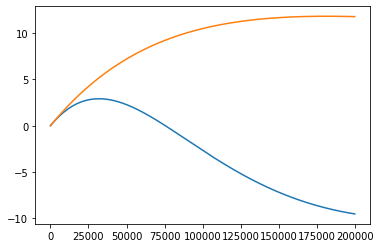

In [102]:
plt.figure()
plt.plot(data[:][0])
plt.plot(data[:][1])
plt.show()